In [1]:
import numpy as np
import cvxopt as cv
import math
from sklearn import svm,multiclass
import time
import matplotlib.pyplot as plt
TRAIN_FILE = 'fashion_mnist/train.csv'
TEST_FILE = 'fashion_mnist/test.csv'
VAL_FILE = 'fashion_mnist/val.csv'

In [2]:
# Load data from files
data = np.genfromtxt(TRAIN_FILE,delimiter=',')
tdata = np.genfromtxt(TEST_FILE,delimiter=',')
vdata = np.genfromtxt(VAL_FILE,delimiter=',')

In [3]:
C = 1.0
y = 0.05

In [4]:
# Gaussian Kernel
def gaussian(y,v):
    return math.exp(-y * v)
GAUS = np.vectorize(gaussian)

In [5]:
def traingaus(GP,Y,M):
#     M = len(Y)
    print("Training on gaussian kernel")
    P = cv.matrix(np.matmul(Y.T,Y) * GP)
    # column vector with all -1
    Q = cv.matrix(-1 * np.ones((M,1)).astype(float))
    G = cv.matrix(np.vstack((-1 * np.eye(M).astype(float),np.eye(M).astype(float))))
    h = cv.matrix(np.vstack((np.zeros((M,1)).astype(float),C * np.ones((M,1)).astype(float))))
    A = cv.matrix(Y)
    b = cv.matrix([[0]],tc='d')
    print("Finding the optimal solution:")
    solution = cv.solvers.qp(P,Q,G,h)#,A,b)
    return np.array(solution['x'])

# Binary Classifier

In [65]:
def convertY(origY):
    maxv = np.max(origY)
    minv = np.min(origY)
    mid = (maxv + minv) / 2.0
    diff = ( maxv - minv )/2.0
    return (origY - mid) /diff

In [118]:
# Define classes to classify
d = 9
classes = [d, (d+1)%10] # Binary classification 

In [122]:
classes

[9, 0]

In [119]:
indices = np.where((data[:,-1] == classes[0]) | (data[:,-1]==classes[1]))

In [120]:
# Loading and modifying traindata
# change values to [0,1] from [0,255]
indices = np.where((data[:,-1] == classes[0]) | (data[:,-1]==classes[1]))
X = data[indices,0:784][0] / 255.0
# change classes to {-1,1}
Y = convertY(data[indices,-1])

In [121]:
# Loading test data
indices = np.where((tdata[:,-1] == classes[0]) | (tdata[:,-1]==classes[1]))
tY = convertY(tdata[indices,-1])[0]
tX = (tdata[indices,0:784]/255.0)[0]

# Loading validation data
indices = np.where((vdata[:,-1] == classes[0]) | (vdata[:,-1]==classes[1]))
vY = convertY(vdata[indices,-1])[0]
vX = (vdata[indices,0:784]/255.0)[0]

In [55]:
# returns alphas as np array, train for both linear and gaussian
def train(islinear,X,Y):
    M = len(X)
    P = np.eye(M).astype(float)
    if(islinear):
        print("Using Linear Kernel")
        # linear kernel
        Z = Y.T * X
        ## M x M array Linear kernel
        P = np.matmul(Z, Z.T)
    else:
        print("Using Gaussian Kernel")
        for i in range(0,M):
            t = X - X[i]
            P[i] = np.sum(t**2,axis=1)
        P = np.matmul(Y.T,Y) * GAUS(y,P)
    P = cv.matrix(P)
    # column vector with all -1
    Q = cv.matrix(-1 * np.ones((M,1)).astype(float))
    G = cv.matrix(np.vstack((-1 * np.eye(M).astype(float),np.eye(M).astype(float))))
    h = cv.matrix(np.vstack((np.zeros((M,1)).astype(float),C * np.ones((M,1)).astype(float))))
    A = cv.matrix(Y)
    b = cv.matrix([[0]],tc='d')
    print("Finding the optimal solution:")
    solution = cv.solvers.qp(P,Q,G,h,A,b)
    return np.array(solution['x'])

In [56]:
def getB(ALPHA,GP):
    R = np.sum(ALPHA * GP, axis=0)
    M = len(R)
    ## assuming arangement is such that top layers is Y = -1 and bottom is Y = 1
    maxv = np.max(R[0:M/2])
    minv = np.min(R[M/2:])
    b = -(maxv + minv)/2.0
    return b

### Linear Kernel

In [57]:
def getLinearParams(alph,X,Y):
    fw = alph * Y.T
    w = np.matmul(fw.T,X)
    R = np.matmul(w,X.T)[0]
    Y = Y[0]
    y1indices = np.where(Y==1)
    y0indices = np.where(Y==-1)
    maxv = np.max(R[y0indices])
    minv = np.min(R[y1indices])
    b = -(maxv+minv)/2.0
    nsv = len(np.where(alph > 1e-05)[0])
    return (w,b,nsv)

In [123]:
linearalpha = train(True,X,Y)
(W,b,nsv) = getLinearParams(linearalpha,X,Y)

Using Linear Kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -1.3874e+02 -7.3498e+03  4e+04  2e+00  1e-12
 1: -7.8159e+01 -3.6059e+03  7e+03  3e-01  1e-12
 2: -2.3151e+01 -8.1591e+02  1e+03  6e-02  6e-13
 3: -8.2817e+00 -3.2692e+02  5e+02  2e-02  3e-13
 4: -1.9531e+00 -5.9043e+01  9e+01  3e-03  8e-14
 5: -6.9181e-01 -1.3465e+01  2e+01  7e-04  3e-14
 6: -3.3850e-01 -2.8374e+00  3e+00  1e-04  2e-14
 7: -3.3182e-01 -1.0866e+00  8e-01  2e-16  2e-14
 8: -4.8517e-01 -8.0175e-01  3e-01  2e-16  2e-14
 9: -5.4774e-01 -6.8892e-01  1e-01  2e-16  2e-14
10: -5.8820e-01 -6.2264e-01  3e-02  2e-16  2e-14
11: -6.0131e-01 -6.0673e-01  5e-03  2e-16  2e-14
12: -6.0378e-01 -6.0391e-01  1e-04  3e-16  2e-14
13: -6.0384e-01 -6.0384e-01  2e-06  2e-16  2e-14
14: -6.0384e-01 -6.0384e-01  2e-08  2e-16  2e-14
Optimal solution found.


In [124]:
print("Number of Support Vectors: "+str(nsv))

Number of Support Vectors: 57


In [125]:
print("b: "+str(b))

b: -0.763733306012551


In [126]:
# Test data
testValues = (np.matmul(W,tX.T) + b)[0]
testPrediction = [1 if val>=0 else -1 for val in testValues]
testCorrect = len(np.where(testPrediction == tY)[0])
testAccuracy = float(testCorrect)/float(len(tY))
print("Test Accuracy: " + str(testAccuracy))

Test Accuracy: 1.0


In [127]:
# validation data
validationValues = (np.matmul(W,vX.T) + b)[0]
validationPrediction = [1 if val >=0 else -1 for val in validationValues]
validationCorrect = len(np.where(validationPrediction==vY)[0])
validationAccuracy = float(validationCorrect)/float(len(vY))
print("Validation Accuracy: "+str(validationAccuracy))

Validation Accuracy: 0.998


### Gaussian Kernel

In [13]:
# Calculate Squared sum matrix
M = len(X)
SSM = np.eye(M).astype(float)
for i in range(0,M):
    SSM[i] = np.sum((X-X[i])**2,axis=1)
# Gaussian of SSM
GM = GAUS(y,SSM)

In [14]:
gaussianalpha = traingaus(GM,Y,M)

Training on gaussian kernel
(4500, 4500)
(4500, 1)
(9000, 4500)
(9000, 1)
(1, 4500)
(1, 1)
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -1.9038e+02 -6.8423e+03  3e+04  2e+00  1e-15
 1: -1.3653e+02 -3.2508e+03  5e+03  2e-01  1e-15
 2: -1.2184e+02 -7.0369e+02  7e+02  2e-02  2e-15
 3: -1.4921e+02 -2.9557e+02  2e+02  5e-03  2e-15
 4: -1.6366e+02 -2.1398e+02  5e+01  1e-03  1e-15
 5: -1.7107e+02 -1.8751e+02  2e+01  6e-05  1e-15
 6: -1.7361e+02 -1.8125e+02  8e+00  2e-05  1e-15
 7: -1.7485e+02 -1.7826e+02  3e+00  2e-16  1e-15
 8: -1.7577e+02 -1.7650e+02  7e-01  2e-16  1e-15
 9: -1.7598e+02 -1.7614e+02  2e-01  2e-16  1e-15
10: -1.7604e+02 -1.7605e+02  7e-03  2e-16  1e-15
11: -1.7604e+02 -1.7604e+02  1e-04  2e-16  1e-15
Optimal solution found.


In [15]:
fW = gaussianalpha * Y.T

In [16]:
nsv = len(np.where(gaussianalpha>1e-05)[0])
print("Number of Support Vectors: "+str(nsv))

Number of Support Vectors: 818


In [17]:
# Get B
tmp = np.sum(fW * GM, axis=0)
y1indices = np.where(Y[0]==1)
yn1indices = np.where(Y[0]==-1)
maxv = np.max(tmp[yn1indices])
minv = np.min(tmp[y1indices])
b = -(maxv + minv)/2.0
print("b: "+str(b))

b: 0.4506163743867606


In [18]:
# Test data
tSSM = np.ones((len(X),len(tX))).astype(float)
for i in range(0,len(X)):
    tSSM[i] = np.sum((tX - X[i])**2,axis = 1)
tGM = GAUS(y,tSSM)
testValues = np.sum(fW* tGM, axis=0) + b
testPrediction = [1 if val>=0 else -1 for val in testValues]
testCorrect = len(np.where(testPrediction == tY)[0])
testAccuracy = float(testCorrect)/float(len(tY))
print("Test Accuracy: " + str(testAccuracy))

Test Accuracy: 0.971


In [19]:
# Validation data
vSSM = np.ones((len(X),len(vX))).astype(float)
for i in range(0,len(X)):
    vSSM[i] = np.sum((vX - X[i])**2,axis = 1)
vGM = GAUS(y,vSSM)
validationValues = np.sum(fW* vGM, axis=0) + b
validationPrediction = [1 if val>=0 else -1 for val in validationValues]
validationCorrect = len(np.where(validationPrediction == vY)[0])
validationAccuracy = float(validationCorrect)/float(len(vY))
print("Validation Accuracy: " + str(validationAccuracy))

Validation Accuracy: 0.972


## sklearn svm

### Linear Kernel

In [ ]:
# Training
linearclf = svm.SVC(C=1.0,kernel='linear')
linearclf.fit(X,Y[0])

In [ ]:
print("Number of Support Vectors = "+str(np.sum(linearclf.n_support_)))

In [ ]:
# Test data
R = linearclf.predict(tX)
Correct = len(np.where(R == tY)[0])
print("Test Accuracy: "+str(float(Correct)/float(len(R))))

In [ ]:
# Validation data
R = linearclf.predict(vX)
Correct = len(np.where(R == vY)[0])
print("Validation Accuracy: "+str(float(Correct)/float(len(R))))

### Gaussian Kernel

In [ ]:
# Training
gaussianclf = svm.SVC(C=1.0,kernel='rbf',gamma=y)
gaussianclf.fit(X,Y[0])

In [ ]:
print("Number of Support Vectors = "+str(np.sum(gaussianclf.n_support_)))

In [ ]:
# Test data
R = gaussianclf.predict(tX)
Correct = len(np.where(R == tY)[0])
print("Test Accuracy: "+str(float(Correct)/float(len(R))))

In [ ]:
# Validation data
R = gaussianclf.predict(vX)
Correct = len(np.where(R == vY)[0])
print("Validation Accuracy: "+str(float(Correct)/float(len(R))))

# Multi Class Classifier

In [ ]:
# Load data
allX = data[:,0:784] / 255.0
Y = data[:,-1]

In [ ]:
# create a dict containing all rows for a class in class key
X = {}
for i in range(0,len(allX)):
    if Y[i] not in X:
        X[Y[i]] = [allX[i]]
    else:
        X[Y[i]].append(allX[i])

In [ ]:
# Test data
tX = tdata[:,0:784]/255.0
tY = tdata[:,-1]

In [ ]:
# Validation data
vX = vdata[:,0:784]/255.0
vY = vdata[:,-1]

In [ ]:
## Alphas and b for different classes
ALPHAxY = np.zeros((10,10,4500,1)).astype(float)
b = np.zeros((10,10)).astype(float)

In [ ]:
# Load saved Alphas and b
ALPHAxY = np.load('alphxy.npy')
b = np.load('b.npy')

In [ ]:
def ip(G,X,i):
    G[i] = np.sum((X-X[i])**2, axis=1)
IP = np.vectorize(ip)

In [ ]:
# fill upper triangle with alphas
Yi = np.ones(2250).astype(float)
st = time.time()
for i in range(0,10):
    for j in range(i+1,10):
        print("training for "+str(i) + " " + str(j))
        trainX = np.vstack((X[i],X[j]))
        # treating bigger class as 1 and smaller as -1
        trainY = np.asarray([np.hstack((-1.0*Yi,Yi))]).astype(float)
        GP = np.eye(len(trainX)).astype(float)
        M = len(trainX)
        for f in range(0,M):
#             t = trainX - trainX[f]
#             GP[f] = np.sum(t*t,axis=1)
            GP[f] = np.sum((trainX - trainX[f])**2,axis=1)
        GP = GAUS(y,GP)
        ALPHAxY[i][j] = (traingaus(GP,trainY,M) * trainY.T)
        b[i][j] = getB(ALPHAxY[i][j],GP)
        print(time.time()-st)

In [ ]:
# save generated Alphaxy and B
np.save('alphxy.npy',ALPHAxY.astype(np.float32))
np.save('b.npy',b)

In [ ]:
# Testing, returns accuracy and cnfmat, assuming ALPHAxY and b are defined globally
def testing(tX,tY):
    M = 4500
    Votes = np.zeros((45,len(tX))).astype(np.int64)
    tx = np.ones((M,len(tX))).astype(float)
    st = time.time()
    index = 0
    # Iterate over all i,j to get vote from each classifier
    for i in range(0,10):
        for j in range(i+1,10):
            print("Voting b/w classes "+str(i) + " and "+ str(j))
            trainX = np.vstack((X[i],X[j]))
            for k in range(0,M):
                tx[k] = np.sum((tX - trainX[k])**2,axis = 1)
            fW = ALPHAxY[i][j]
            R = np.sum(fW * GAUS(y,tx), axis=0) + b[i][j]
            # converting values to classes
            v = [j if cls>=0 else i for cls in R]
            Votes[index] = v
            index+=1
    Votes = Votes.T
    # Create Final class from votes, tie ends with assigning max class
    R = np.zeros(len(tX))
    for i in range(0,len(tX)):
        tmp = np.bincount(Votes[i])
        R[i] = np.where(tmp == tmp.max())[0][-1]
    cnfmat = np.zeros((10,10))
    # Number of correct predictions
    correct = len(np.where(R == tY)[0])
    accuracy = float(correct)/float(len(tY))
    for i in range(0,len(tY)):
        cnfmat[int(R[i])][int(tY[i])] +=1
    return (accuracy,cnfmat)

In [ ]:
# Test data
tX = tdata[:,0:784]/255.0
tY = tdata[:,-1]
(TestAccuracy, TestConfusionMatrix) = testing(tX,tY)
print("Test Accuracy: "+str(TestAccuracy))
print("Confusion Matrix for Test data:")
print(TestConfusionMatrix)

In [ ]:
# Validation data
vX = vdata[:,0:784]/255.0
vY = vdata[:,-1]
(ValidationAccuracy,ValidationConfusionMatrix) = testing(vX,vY)
print("Validation Accuracy: "+str(ValidationAccuracy))
print("Confusion Matrix for Validation data:")
print(ValidationConfusionMatrix)

## sklearn svm

In [ ]:
# Multi class using SK learn 1 vs 1
# Initialize classifier
classifier = multiclass.OneVsOneClassifier(svm.SVC(kernel='rbf',C=1,gamma=0.05))

In [ ]:
Classifiers = []

In [ ]:
# Train
Yi = np.ones(2250).astype(float)
# numCLF = 0
st = time.time()
for i in range(0,10):
    for j in range(i+1,10):
        print("training for "+str(i) + " " + str(j))
        trainX = np.vstack((X[i],X[j]))
        # treating bigger class as 1 and smaller as -1
        trainY = np.asarray(np.hstack((-1.0*Yi,Yi))).astype(float)
        M = len(trainX)
        clf = svm.SVC(kernel='rbf',C=1,gamma=0.05)
        clf.fit(trainX,trainY)
        Classifiers.append(clf)
print(time.time()-st)

In [ ]:
# assuming classifier is global
def svmtesting(tX,tY):
    M = 4500
    Votes = np.zeros((45,len(tX))).astype(np.int64)
    tx = np.ones((M,len(tX))).astype(float)
    st = time.time()
    index = 0
    # Iterate over all i,j to get vote from each classifier
    numCLF = 0
    for i in range(0,10):
        for j in range(i+1,10):
#             print("Voting b/w classes "+str(i) + " and "+ str(j))
            clf = Classifiers[numCLF]
            numCLF += 1
            R = clf.predict(tX)
            # converting values to classes
            v = [j if cls>=0 else i for cls in R]
            Votes[index] = v
            index+=1
    Votes = Votes.T
    # Create Final class from votes, tie ends with assigning max class
    R = np.zeros(len(tX))
    for i in range(0,len(tX)):
        tmp = np.bincount(Votes[i])
        R[i] = np.where(tmp == tmp.max())[0][-1]
    cnfmat = np.zeros((10,10))
    # Number of correct predictions
    correct = len(np.where(R == tY)[0])
    accuracy = float(correct)/float(len(tY))
    for i in range(0,len(tY)):
        cnfmat[int(R[i])][int(tY[i])] +=1
    return (accuracy,cnfmat)
    R = classifier.predict(tX)
    cnfmat = np.zeros((10,10)).astype(int)
    correct = len(np.where(R==tY)[0])
    for i in range(0,len(R)):
        cnfmat[int(R[i])][int(tY[i])]+=1
    accuracy = float(correct)/float(len(tY))
    return (accuracy,cnfmat)

In [ ]:
# Test data
tX = tdata[:,0:784]/255.0
tY = tdata[:,-1]
(TestAccuracy, TestConfusionMatrix) = svmtesting(tX,tY)
print("Test Accuracy: "+str(TestAccuracy))
print("Confusion Matrix for Test data:")
print(TestConfusionMatrix)

In [ ]:
# Validation data
vX = vdata[:,0:784]/255.0
vY = vdata[:,-1]
(ValidationAccuracy,ValidationConfusionMatrix) = svmtesting(vX,vY)
print("Validation Accuracy: "+str(ValidationAccuracy))
print("Confusion Matrix for Validation data:")
print(ValidationConfusionMatrix)

### Finding C

In [48]:
Cs = [1e-5,1e-3,1,5,10]

In [ ]:
# K-cross validation
# assuming data is already shuffled
k = 5
BS = allX.shape[0]/k
Accuracies=[]
st = time.time()
for c in Cs:
    correct = 0
    clf = svm.SVC(kernel='rbf',C=c,gamma=0.05)
    # Treat i-th block as validation set
    for i in range(0,k):
        print("Block "+str(i+1))
        trainX = np.vstack((allX[:i*BS],allX[(i+1)*BS:]))
        trainY = np.hstack((Y[:i*BS],Y[(i+1)*BS:]))
        clf.fit(trainX,trainY)
        R = clf.predict(allX[i*BS:(i+1)*BS])
        y = Y[i*BS:(i+1)*BS]
        correct += len(np.where(R==y)[0])
        print(time.time() - st)
    Accuracy = float(correct)/float(len(allX))
    Accuracies.append(Accuracy)
    print("C: "+str(c)+", " + "Average Validation accuracy: "+str(Accuracy))
print(Accuracies)

In [ ]:
# Test and Validation Accuracies
TestAccuracies = []
ValidationAccuracies = []
for c in Cs:
    clf = svm.SVC(kernel='rbf',C=c,gamma=0.05)
    clf.fit(allX,Y)
    testCorrect = len(np.where(clf.predict(tX)==tY)[0])
    testAccuracy = float(testCorrect)/float(len(tY)) 
    TestAccuracies.append(testAccuracy)
    validationCorrect = len(np.where(clf.predict(vX)==vY)[0])
    validationAccuracy = float(validationCorrect)/float(len(vY))
    ValidationAccuracies.append(validationAccuracy)
    print("C: "+str(c)+", Test data Accuracy: "+str(testAccuracy)+", Validation data Accuracy: "+str(validationAccuracy))

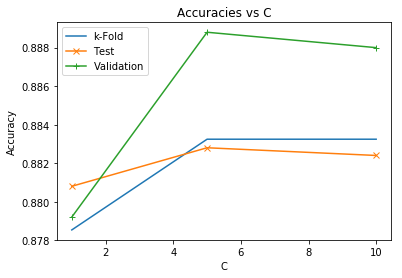

In [49]:
plt.plot(Cs[2:],Accuracies[2:])
plt.plot(Cs[2:],TestAccuracies[2:],marker='x')
plt.plot(Cs[2:],ValidationAccuracies[2:],marker='+')
plt.legend(['k-Fold','Test','Validation'])
plt.title("Accuracies vs C")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig('AccuraciesTop3.png')